In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import pysam
from functions_ import *
from plotting import *
from DMS_utils import *

ref = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaatgtccgcgaaagcgcagaacgatccgctgctgccgggctatagctttaacgcacatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgagaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggcctctatagcgaactgctgacaattaacctgctggaacagctgctgctgcgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagccctagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggcctcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtgaacgatgtggcggtgaaactgagcgggtaaggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper()



In [77]:
ref = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaAtgtccgAggaagcgcagaacgatccgctgctgccgggctatagctttaacgcgcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgcgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccgctatagcgaactgctggcgattaacctgAtAgaacagctgctgctgcgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccgagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccAcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper() ## R5

In [69]:
import pysam

# Open the BAM file
bamfile = pysam.AlignmentFile("/var/lib/minknow/data/basecalling/pass/alignment/barcode06/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.bam", "r")

# Prepare to store mutations by read
read_mutations = {}
excluded_reads = 0
included_reads = 0

# Iterate over reads in the SAM file
for read in bamfile.fetch():
    mutations = []
    try:
        md_tag = read.get_tag("MD")  # Try to get the MD tag
        included_reads += 1
    except KeyError:
        excluded_reads += 1 
        continue  # If missing, skip this read
    
    # Iterate over the aligned pairs of the read
    for pos, ref_base_index, query_base in read.get_aligned_pairs(with_seq=True):
        # Fetch the actual reference base using the index
        if ref_base_index is not None:  # Make sure there is a reference base
            #print(pos, ref_base_index, query_base)
            ref_base = ref[ref_base_index]
        
            if query_base != ref_base:  # A mismatch (SNP)
                mutations.append((pos, query_base))

    # Detect indels in CIGAR string
    #print(read.cigartuples)
    for pos,(cigop, length) in enumerate(read.cigartuples):
        if cigop == 1:  # Insertion (I)
            mutations.append((pos, f"I", read.query_sequence[pos:pos+length]))
        elif cigop == 2:  # Deletion (D)
            mutations.append(((pos, f"D", ref[pos:pos+length]))) 
    
    
    read_mutations[read.query_name] = mutations

# Print out the mutations found in each read
for read_name, mutations in read_mutations.items():
    print(f"Read: {read_name} Mutations: {mutations}")


Read: 118fd859-06f9-4c95-a5bf-b5f2bc3eb27f Mutations: [(302, 'c'), (304, 'a'), (348, 'a'), (565, 'a'), (670, 'g'), (699, 'g'), (748, 'a'), (750, 'a'), (760, 'c'), (762, 'g'), (957, 'c'), (1015, 'a'), (1353, 't'), (1396, 'g'), (1481, 't'), (1517, 'g'), (1763, 'c'), (1, 'D', 'AA'), (3, 'I', 'T'), (5, 'D', 'G'), (7, 'D', 'A'), (9, 'D', 'CT')]
Read: 3b269860-97fc-406d-808a-5d4f2a2dbcf3 Mutations: [(10, 'a'), (11, 'c'), (71, 'c'), (310, 'c'), (356, 'a'), (413, 't'), (498, 't'), (571, 'a'), (697, 'g'), (714, 't'), (740, 't'), (757, 'a'), (759, 'a'), (769, 'c'), (771, 'g'), (1012, 'g'), (1013, 'c'), (1018, 'g'), (1074, 'a'), (1104, 't'), (1223, 'c'), (1227, 'g'), (1281, 'c'), (1365, 't'), (1453, 't'), (1495, 't'), (1627, 'g'), (1727, 't'), (2, 'I', 'A'), (4, 'D', 'G'), (6, 'D', 'A'), (8, 'I', 'AAT'), (10, 'I', 'T'), (12, 'I', 'T'), (14, 'I', 'C'), (16, 'D', 'A'), (18, 'I', 'A'), (20, 'D', 'A'), (22, 'D', 'A'), (24, 'I', 'A'), (26, 'D', 'C'), (28, 'D', 'T'), (30, 'D', 'A'), (32, 'D', 'TC'), (3

In [47]:

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}


def translate_dna2aa(orf: str) -> str:
  """
  Ignorant DNA to protein translation.
  Stops on anything not from the genetic code and does not check for length.
  """
  protein = ''
  # Interestingly enough timing revealed that bad practices (loops and string addition)
  # resulted in the fastest translation (for a 150 base dummy sequence)
  for i in range(0, (len(orf) // 3) * 3, 3):
    try:
      protein += genetic_code[orf[i:i + 3]]
    except KeyError:
      protein += 'X'
  return protein

In [70]:
import pysam

# Open the BAM file
bamfile = pysam.AlignmentFile("/var/lib/minknow/data/basecalling/pass/alignment/barcode06/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.bam", "r")

# Prepare to store mutations by read
read_mutations = {}
excluded_reads = 0
included_reads = 0


# get_aligned_pairs(self, matches_only=False, with_seq=False, with_cigar=False)
# a list of aligned read (query) and reference positions.
# Each item in the returned list is a tuple consisting of the 0-based offset from the start of the read sequence followed by the 0-based reference position.
# For inserts, deletions, skipping either query or reference position may be None.
# For padding in the reference, the reference position will always be None.

# Iterate over reads in the SAM file
all_references = []
for read in bamfile.fetch():
    alignment_start = read.reference_start 
    seq = read.query_sequence
    refined_seq = ""
    for cigar_tuple in read.get_aligned_pairs(with_seq=True, with_cigar=True): 
        if cigar_tuple[-1].value == 0: ## MATCH
            refined_seq += seq[cigar_tuple[0]]
        elif cigar_tuple[-1].value == 2: ## DELETION
            refined_seq += "-"
        
    if alignment_start <10: 
        cut_start = 9-alignment_start
        refined_seq = refined_seq[cut_start:]
        all_references.append(refined_seq)
        
        


In [53]:

def characterize_DMS_blast_alignment(aligned_reads, ref, data_type = "AA"):
    """
    Function to characterize the DMS alignments, by counting the number of insertions, deletions and substitutions per position

    args:
    DMS_alignments: dict, with the sequences of insert that is mutated 
    ref: str, reference DNA sequence 
    data_type: str, "AA", "DNA" or "Codons
    read_dir: str, "R1" or "R2"
    cut_to_same_start: bool, if True, the sequences are cut to the same start position, otherwise, start and end positions have to be provided as query_from and query_to keys

    returns:
    all_variants: dict, with the counts of the variants per position
    indels_freq: pd.DataFrame, with the counts of insertions and deletions per position (normalized to # alignments)
    enrichment_counts: pd.DataFrame, with the counts of the variants per position, with the reference sequence masked
    enrichment_relative: pd.DataFrame, with the relative counts of the variants per position, with the reference sequence masked

    """

    all_variants = {}
    seq_with_off_target_indels = 0
    included_seq = 0
    indels = pd.DataFrame(columns = range(len(ref)), index = ["insertion"], data = 0)

    ref = translate_dna2aa(ref) if data_type == "AA" else ref

    if data_type == "AA":
        for idx in range(len(ref)):
            all_variants[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                                    'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                                    'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                                    'W':0, 'Y':0, '*':0, 'X':0} ## X: are triplets with missing nucleotides (i.e. in the aligned seq, "-" is present), that would lead to a frameshift
    elif data_type == "DNA": 
        for idx in range(len(ref)):
            all_variants[idx] = {'A':0, 'C':0, 'G':0, 'T':0, "-":0}

    for alignment in aligned_reads:
        
        if "-" in alignment: ## track indels
            seq_with_off_target_indels += 1
            shift = 0 ## here, we count the shift of the position compared to the reference, that occurs if there is an insertion in the qseq 

            for idx,nt in enumerate(alignment): 
                pos = idx - shift # adjust for the shift in the index, due to prior insertions

                if nt == "-":
                    indels.loc["insertion", pos] += 1
                    shift += 1 ## to correct for the shift in the index, due to the insertion


        if data_type == "AA":
            alignment = translate_dna2aa(alignment)
        
        for idx, variant in enumerate(alignment): 
            all_variants[idx][variant] += 1
       
    indels_freq = indels/len(aligned_reads)
    print(seq_with_off_target_indels, "sequences have off target indels")
    print(len(aligned_reads), "sequences are included in the enrichment analysis")

    all_variants = pd.DataFrame.from_dict(all_variants)

    enrichment_counts, enrichment_relative = mask_ref_in_variants_df(variant_df=all_variants, ref_seq=ref, data_type=data_type)
    

    return all_variants, enrichment_counts,enrichment_relative, indels_freq

In [78]:
data_type = "AA"
all_variants, enrichment_counts,enrichment_relative, indels_freq = characterize_DMS_blast_alignment(aligned_reads = all_references, ref = ref[9:], data_type = "AA")


3877 sequences have off target indels
3925 sequences are included in the enrichment analysis


In [96]:
enrichment_relative.iloc[:,297//3:-727//3]

,99,100,101,102,103,104,105,106,107,108,...,401,402,403,404,405,406,407,408,409,410
A,0.000510,NaN,0.000000,0.000000,0.000510,0.000765,0.000000,0.000000,0.000000,0.000255,...,NaN,0.000000,0.000000,0.000256,0.003846,0.001282,NaN,NaN,0.000000,0.000513
C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D,0.000510,0.000000,0.000510,0.002295,NaN,0.000000,0.000000,0.000000,0.000000,0.001020,...,0.000000,0.000256,0.001795,0.000000,NaN,0.000513,0.000000,0.000256,0.000000,0.000000
E,NaN,0.002805,0.001020,0.000000,0.003826,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.001282,NaN,0.000513,0.000000,0.008462,0.005385
F,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000769,0.000256,0.000256,0.000000,0.000256,0.000000,0.000000
G,0.001020,0.000765,0.000000,0.000000,0.003315,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000513,0.000513,0.000256,0.000000,0.001026,0.000513,0.000000,0.000256,0.000000,NaN
H,0.000000,0.000000,0.008671,0.001530,0.007141,0.000255,0.000000,0.000255,0.000000,0.000000,...,0.000000,0.000256,0.000000,0.000000,0.002308,0.000256,0.000000,0.000000,0.000000,0.000000
I,0.000000,0.000000,0.000000,0.001020,0.000000,0.000000,0.000255,0.000255,0.000000,0.000000,...,0.000000,0.000000,0.000769,NaN,0.000256,0.000000,0.000000,0.000256,0.000000,0.000000
K,0.030604,0.000000,0.003315,0.003060,0.000000,0.000255,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005385,0.002051,0.000256,0.000256,0.110769,0.000000,0.000000,NaN,0.000000
L,0.000000,0.000000,0.000255,0.000000,0.000000,0.012755,NaN,NaN,0.001276,0.000000,...,0.000000,0.000000,0.000256,0.000256,0.000000,0.000256,0.000256,0.000000,0.000000,0.000000


In [101]:
translate_dna2aa(ref[297:-727])

'MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGS'

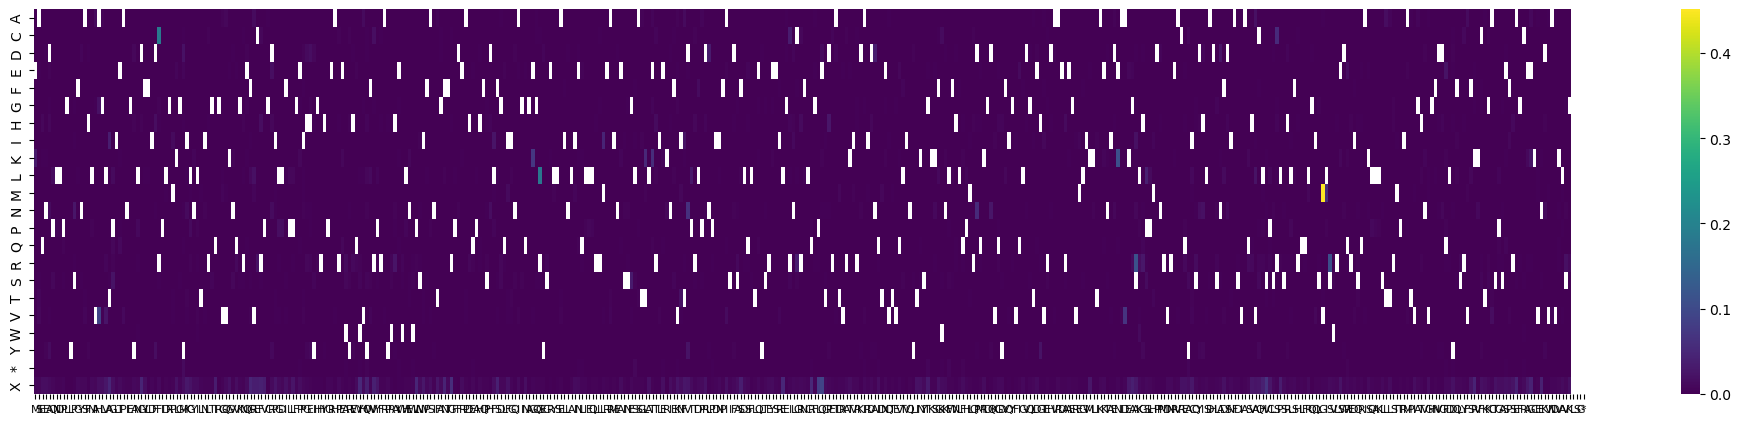

In [109]:
fig, axes = plt.subplots(figsize = (25,5))
sns.heatmap(enrichment_relative.iloc[:,297//3:-355//3], xticklabels=translate_dna2aa(ref[297:-355]), ax = axes, cmap = "viridis")
plt.xticks(rotation=1, fontsize = 8)
plt.show()


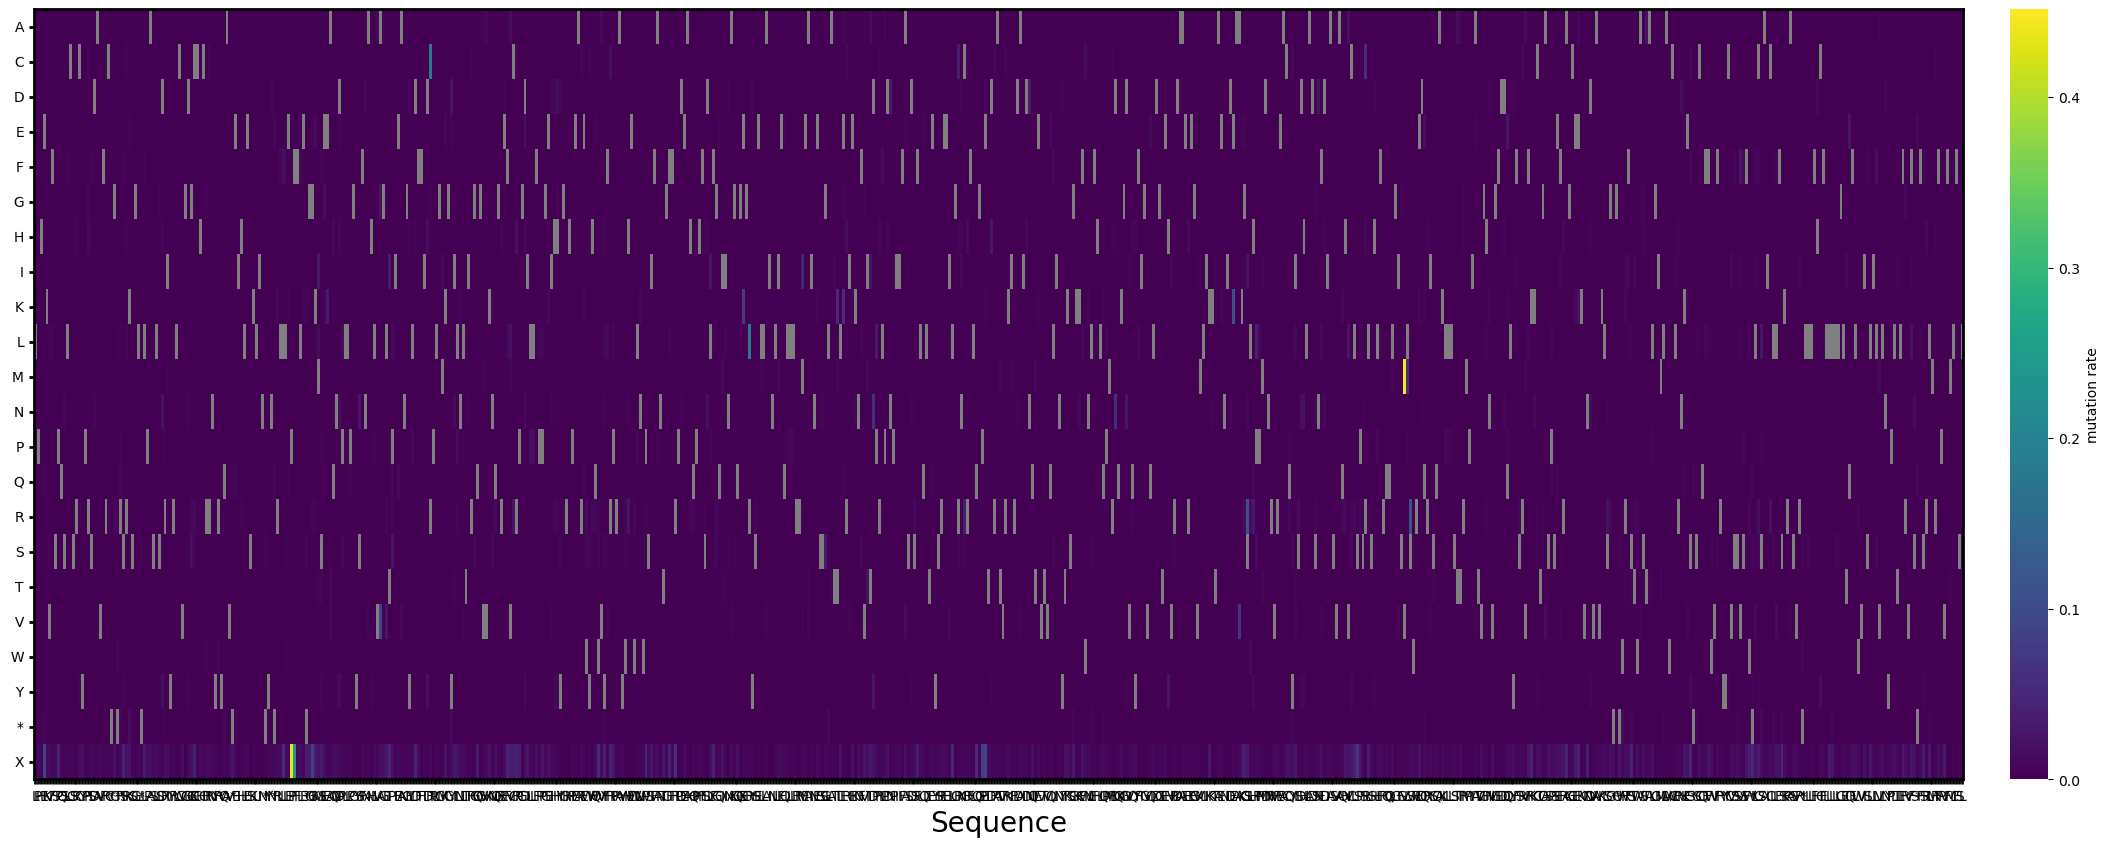

In [79]:
plot_mutation_enrichment(variants_df=enrichment_relative, ref_seq=ref[9:] if data_type != "AA" else translate_dna2aa(ref[9:]), data_type=data_type)

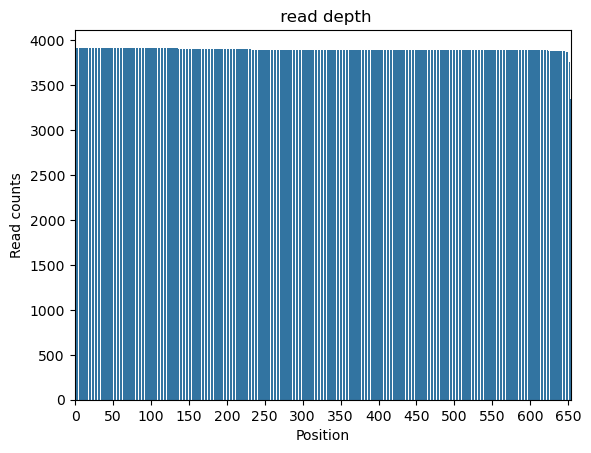

In [55]:
coverage_plot(all_variants.sum())

In [39]:
all_variants

,0,1,2,3,4,5,6,7,8,9,...,644,645,646,647,648,649,650,651,652,653
A,1,0,0,0,1,3,1,0,3,0,...,0,0,0,0,0,0,0,0,0,0
C,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,12,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
E,0,0,0,3542,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
F,73,0,0,0,0,7,3532,0,0,0,...,0,28,0,0,28,0,0,27,0,0
G,0,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
H,1,2,3832,0,0,0,0,6,0,2,...,0,0,0,0,0,0,0,0,0,0
I,14,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
K,0,0,0,5,3573,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
L,3815,2,1,5,2,8,11,0,5,0,...,0,0,0,0,0,0,27,0,0,27


In [1]:
"taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaatgtccgcgaaagcgcagaacgatccgctgctgccgggctatagctttaacgcacatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgagaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggcctctatagcgaactgctgacaattaacctgctggaacagctgctgctgcgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagccctagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggcctcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtgaacgatgtggcggtgaaactgagcgggtaaggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper()

'TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGC

In [4]:
A_count, C_count, G_count, T_count = bamfile.count_coverage("AraC_S170_LOV_R2", quality_threshold=15)


In [28]:
M_cigar = []
I_cigar = []
D_cigar = []

for read in bamfile.fetch():
    cigar_stats = read.get_cigar_stats()
    if len(cigar_stats[0])>2:
        M_cigar.append(cigar_stats[0][0])
        I_cigar.append(cigar_stats[0][1])
        D_cigar.append(cigar_stats[0][2])


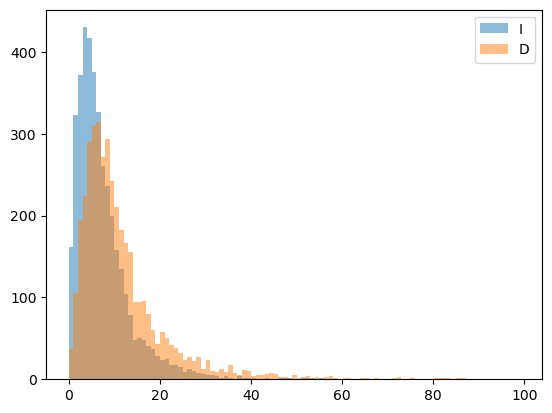

In [32]:
plt.hist(I_cigar, alpha=0.5, label='I', bins=range(0, 100))
plt.hist(D_cigar, alpha=0.5, label='D', bins=range(0, 100))
plt.legend()
plt.show()

In [14]:
y

[(array('I', [1963, 10, 9, 0, 1, 0, 0, 0, 0, 0, 26]),
  array('I', [11, 4, 6, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1969, 2, 3, 0, 1, 0, 0, 0, 0, 0, 17]),
  array('I', [5, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1969, 0, 3, 0, 1, 0, 0, 0, 0, 0, 16]),
  array('I', [2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1969, 5, 3, 0, 1, 0, 0, 0, 0, 0, 16]),
  array('I', [7, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1957, 19, 15, 0, 1, 0, 0, 0, 0, 0, 65]),
  array('I', [24, 13, 10, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1963, 1, 9, 0, 1, 0, 0, 0, 0, 0, 14]),
  array('I', [6, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1966, 6, 6, 0, 1, 0, 0, 0, 0, 0, 21]),
  array('I', [11, 4, 6, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1962, 13, 10, 0, 1, 0, 0, 0, 0, 0, 32]),
  array('I', [16, 8, 7, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1962, 6, 10, 0, 1, 0, 0, 0, 0, 0, 26]),
  array('I', [11, 4, 6, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1951, 4, 21, 0, 1, 0, 0, 0, 0, 0, 46]),
  arra

In [5]:
x = pd.DataFrame([A_count, C_count, G_count, T_count], index=["A", "C", "G", "T"])


In [7]:
import numpy as np

In [8]:
x_masked = x.copy()
for idx, ref_nt in enumerate(ref): 
    x_masked.loc[ ref_nt,idx] = np.nan


<Axes: >

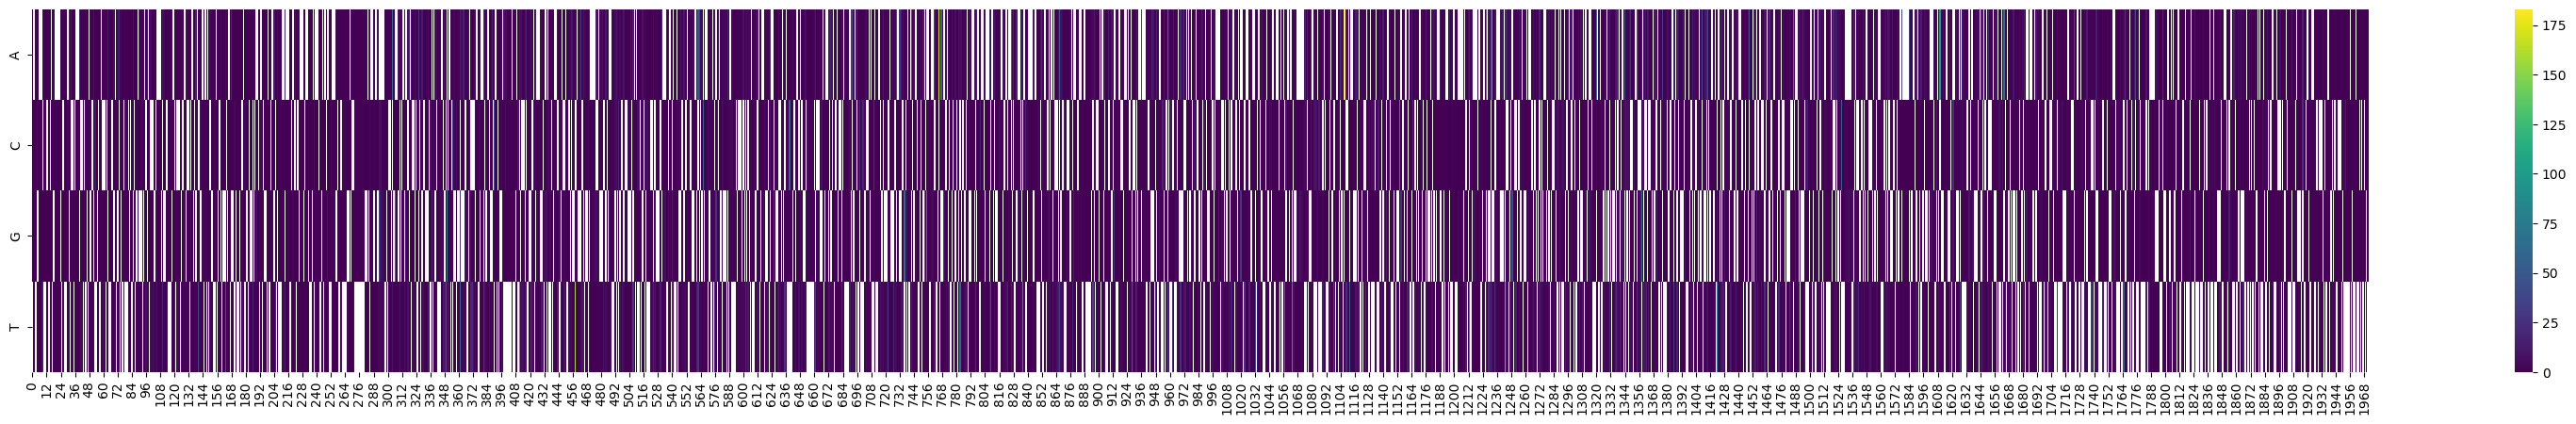

In [9]:
import seaborn as sns
plt.figure(figsize=(40, 5))
sns.heatmap(x_masked, cmap="viridis")

In [10]:
mut_rate = x_masked.sum()

In [11]:
coverage = x.sum()

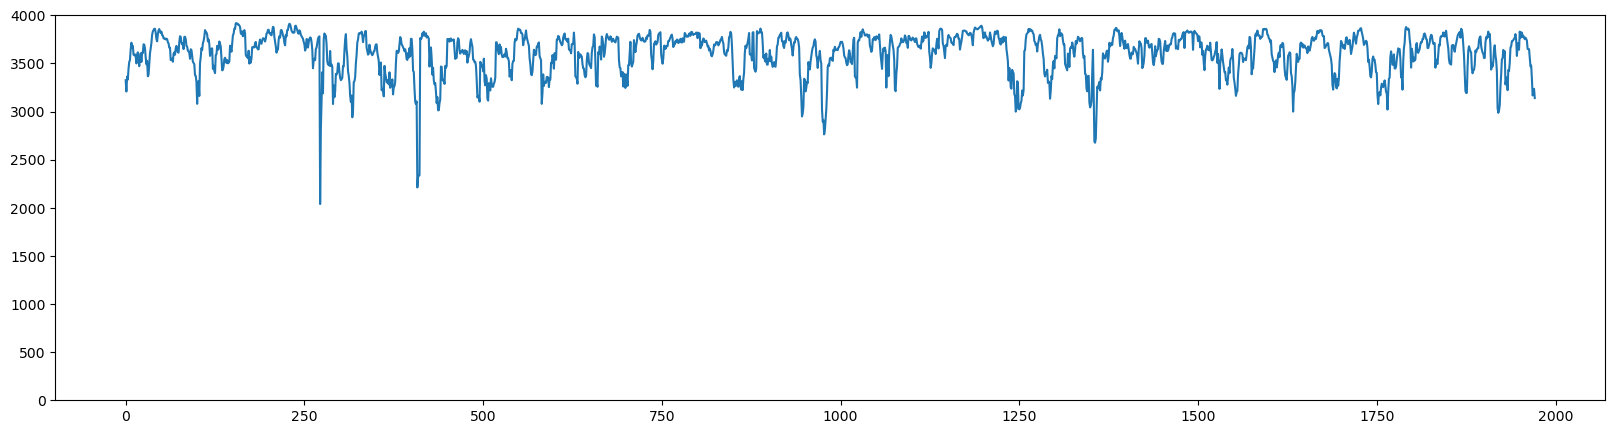

In [12]:
plt.figure(figsize=(20, 5))
plt.ylim(0, 4000)
plt.plot(coverage)

<Axes: >

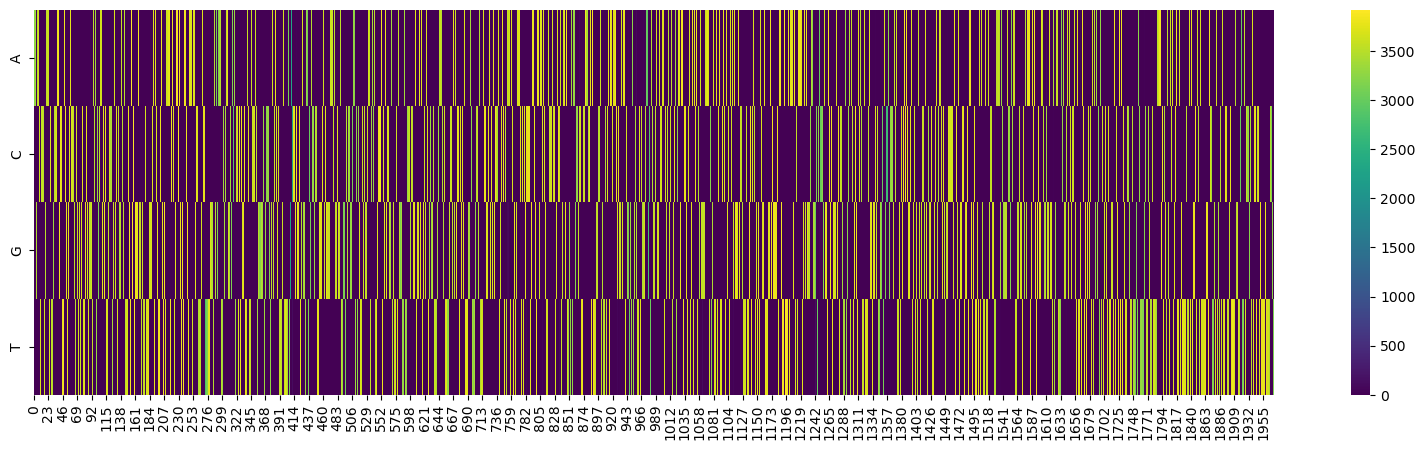

In [58]:
import seaborn as sns
plt.figure(figsize=(20, 5))
sns.heatmap(x, cmap="viridis")